# Análisis de sistemas electorales para la Cámara de Diputadas y Diputados de Chile

En el presente informe, se utilizan los datos de las elecciones parlamentarias
de Chile de 2021 para simular la distribución de escaños en la Cámara de
Diputadas y Diputados bajo distintos sistemas electorales. Para cada sistema,
se presentan ventajas y desventajas, justificadas mediante un análisis numérico
de los resultados (e.g. cálculo del [índice de
Gallagher](https://en.wikipedia.org/wiki/Gallagher_index) y el [índice de
Loosemore-Hanby](https://en.wikipedia.org/wiki/Loosemore%E2%80%93Hanby_index)
para ver disproporcionalidad, y de la [cantidad efectiva de
partidos](https://en.wikipedia.org/wiki/Effective_number_of_parties) para ver
fragmentación).

Se proponen los siguientes sistemas (en cursiva los que aún no se han
analizado):

- Proporcional por distrito
    - D'Hondt estándar (actualmente usado)
    - D'Hondt con umbral nacional (actualmente en discusión)
    - D'Hondt sin pactos
- *Proporcional nacional*
    - *D'Hondt nacional con umbral*
- *Bipartidistas*
    - *Binomial*
    - *Uninominal (first-past-the-post)*
- *Mixtos*
    - *Mixed-Member Proportional / Additional Member System*
    - *D'Hondt con escaños niveladores*
    - *Binomial con escaños niveladores*
- *Sistema biproporcional*

In [1]:
import numpy as np
import pandas as pd

from data_load_utils import *
from systems import *
from apportionment import Apportionment

## Carga de datos

Primero, se carga a un dataframe el archivo `datos.csv` con una representación
ordenada de todas las votaciones obtenidas durante la elección parlamentaria,
exceptuando candidatos independientes fuera de pacto. La creación de este
archivo fue a partir de los resultados oficiales de las elecciones entregados
por el [Tricel](https://tricel.cl/resultados-de-elecciones/). En el anexo
[`carga_datos.ipynb`](carga_datos.ipynb) se puede ver este proceso con mayor
profundidad.

In [2]:
df = pd.read_csv("datos.csv", index_col=0)

Para las simulaciones en las cuales no se utilizan pactos, creamos una copia
del dataframe donde el pacto de cada candidato es reemplazado por su partido.

In [3]:
df_no_pact = df.copy()
df_no_pact["pact"] = df_no_pact["party"]

En las simulaciones usando D'Hondt, se mantendrá la distribución de escaños del
congreso actual para cada uno de los 28 distritos.

In [4]:
district_seats = pd.Series(
    np.array(
        [3, 3, 5, 5, 7, 8, 8, 8, 7, 8, 6, 7, 5, 6,
        5, 4, 7, 4, 5, 8, 5, 4, 7, 5, 4, 5, 3, 3]
    ),
    index=range(1, 29)
)

Para las simulaciones que utilizan distritos binomiales y uninominales, se
deben redistribuir los distritos existentes. A cada distrito se le asignó una
cantidad de subdistritos en los cuales dividirse, según su cantidad total de
votantes. La asignación se realizó usando el [método de
Huntington-Hill](https://en.wikipedia.org/wiki/Huntington%E2%80%93Hill_method),
el mismo usado para la asignación de escaños a los distintos estados de los
Estados Unidos en su Cámara de Representantes. Usando este método, se
obtuvieron 50 distritos binomiales y 100 distritos uninominales.

Una vez obtenida la cantidad de subdistritos, los candidatos de cada distrito
se reasignaron intentando que cada pacto tuviese una cantidad "equitativa" de
candidatos en cada subdistrito (es decir, si un pacto tenía 9 candidatos en un
distrito que se dividió en 3, se esperarían 3 candidatos del pacto en cada
subdistrito). Esta reasignación no es ideal, pero es útil para un experimento
más exploratorio que riguroso.

In [5]:
# votos totales por distrito
district_votes = df.groupby("district")["votes"].sum()

# escaños iniciales (1 para cada distrito)
initial_seats = pd.Series([1]*28, index=range(1, 29))

huntington_hill_denominator = lambda x: np.sqrt(x * (x + 1))

# asignación de distritos binomiales
bin_split = assign_seats_to_parties(
    district_votes,
    50,
    initial_seats,
    huntington_hill_denominator
)
df_bin = redistrict_candidates(df, bin_split)
districts_bin = df_bin["district"].drop_duplicates().to_list()
district_seats_bin = pd.Series([2]*len(districts_bin), index=districts_bin)

# asignación de distritos uninominales
mono_split = assign_seats_to_parties(
    district_votes,
    100,
    initial_seats,
    huntington_hill_denominator
)
df_mono = redistrict_candidates(df, mono_split)
districts_mono = df_mono["district"].drop_duplicates().to_list()
district_seats_mono = pd.Series([1]*len(districts_mono), index=districts_mono)

Finalmente, se utiliza el diccionario `colors` para asignar un color RGB a cada partido político (a usarse en las representaciones visuales de cada simulación), y también para ordenar los partidos según el eje izquierda-derecha en los diagramas de hemiciclo.

In [6]:
colors = pd.Series({
    "PTR": "#BE0411",
    "UPA": "#CC0000",
    
    "PC": "#B22222",
    "FREVS": "#008000",
    "COM": "#461D3D",
    "CS": "#FF1455",
    "RD": "#1D4C4F",
    
    "PI": "#000000",
    "PH": "#FF4500",
    "PEV": "#03BF00",
    "PRO": "#E02385",
    
    "PS": "#ED1624",
    "PPD": "#FFA500",
    "PR": "#CD5C5C",
    "PL": "#FFD700",
    "CIU": "#DB8F16",
    "PDC": "#1E90FF",
    
    "PDG": "#00285E",
    "CU": "#037E3B",

    "EVO": "#0CB8E6",
    "PRI": "#4A1C51",    
    "RN": "#024E9A",
    "UDI": "#29398A",
    
    "PNC": "#0000FF",
    "NT": "#000080",

    "PCC": "#000080",
    "PLR": "#22446D",
})

party_order = list(colors.keys())

## Sistemas proporcionales por distrito

Los sistemas proporcionales intentan entregar escaños acorde a la cantidad de
gente que votó por cada partido. Cuando son sistemas por distrito, entonces
cada distrito asigna sus escaños de forma independiente, intentando entregar la
mayor proporcionalidad al interior del distrito.

Características de los sistemas proporcionales por distrito:
- Proporcionalidad a nivel de distrito no necesariamente implica una buena
  proporcionalidad a nivel nacional. En general, cualquier método tenderá a
  sobrerrepresentar partidos que tienen un muy buen rendimiento en pocos
  distritos, versus aquellos que tienen un rendimiento parejo a nivel nacional.
  Además, el [método de
  D'Hondt/Jefferson](https://en.wikipedia.org/wiki/D%27Hondt_method), usado en
  Chile y analizado en esta sección, tiende a favorecer a partidos más grandes
  por sobre los más pequeños.
- Existe un trade-off en el tamaño de los distritos: aumentar la cantidad de
  escaños por distrito aumenta la proporcionalidad a nivel distrital y
  nacional; por otra parte, implica papeletas más grandes y difíciles de
  contar, y un aumento en el tamaño del Congreso o en las áreas que cubren cada
  uno de los distritos (esto último se traduce a una menor "conexión" entre
  diputados y votantes).
- Propenso al "arrastre", donde candidatos con muy pocos votos son electos
  debido a que un compañero de partido/pacto consiguió una proporción enorme de
  los votos. Esto hace mella en la legitimidad del sistema, pues las personas
  ven diputados electos en distritos donde obtuvieron menos del 1% de los
  votos.

### D'Hondt estándar

El sistema de D'Hondt con pactos, y sin ningún tipo de umbral electoral, es
usado en Chile para elecciones parlamentarias desde el año 2017. Cada uno de
los 28 distritos escogen a 3-8 diputados de manera proporcional. Un sistema
similar se usa para el [Congreso de los Diputados de
España](https://en.wikipedia.org/wiki/Elections_in_Spain#Congress_of_Deputies)
y en la [Cámara de Diputados de
Argentina](https://en.wikipedia.org/wiki/Argentine_Chamber_of_Deputies), solo
que con listas cerradas y con algunos distritos mucho más grandes (en teoría
también hay un umbral electoral por distrito, pero en la práctica no afecta
particularmente).

Características del sistema D'Hondt estándar:
- Obtiene una proporcionalidad a nivel nacional aceptable, pero no ideal, con
  índices de disproporcionalidad entre partidos de 7.37% (Gallagher) y 19.47%
  (Loosemore-Hanby). Se obtienen resultados similares a nivel de pactos.
- Se observa una inclinación hacia los pactos más grandes, con los partidos que
  compitieron fuera de pacto (PLR, PDG, PEV) obteniendo muchos menos escaños de
  los que su votación a nivel nacional indicaría.
- La proporcionalidad a nivel de distrito es aceptable, pero puede llegar a ser
  muy baja para algunos distritos; esto es de esperar con distritos que tienen
  pocos escaños. Un 21.6% de los votantes no tienen a ningún candidato de su
  pacto representándolos en su distrito.
- Se genera un importante nivel de arrastre; los 5 diputados menos votados
  obtuvieron bajo un 1.3% de los votos de su distrito, y el diputado mediano
  obtuvo un 6.62% de los votos de su distrito.
- Hay un alto grado de fragmentación partidaria, con 21 partidos representados
  en la Cámara, y 11.6 partidos efectivos. La alta diferencia entre partidos
  reales y efectivos también indica una cantidad importante de partidos con muy
  pocos diputados en el Congreso.

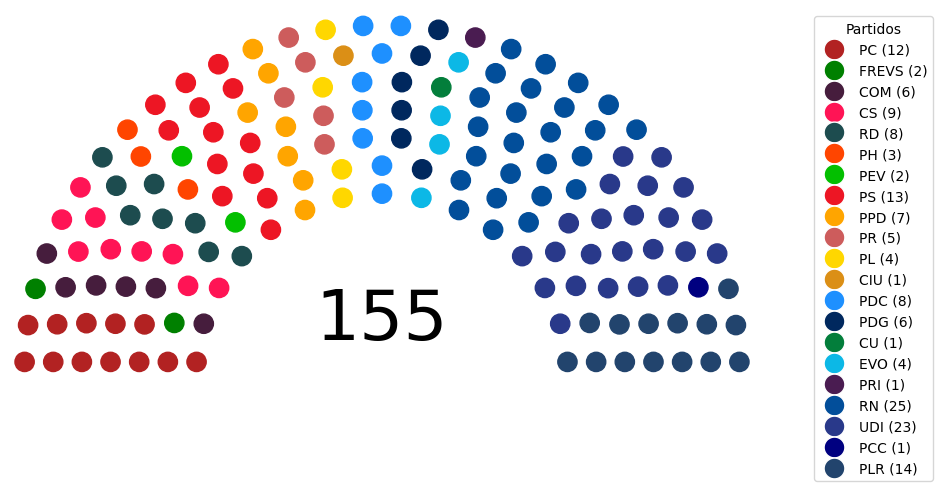

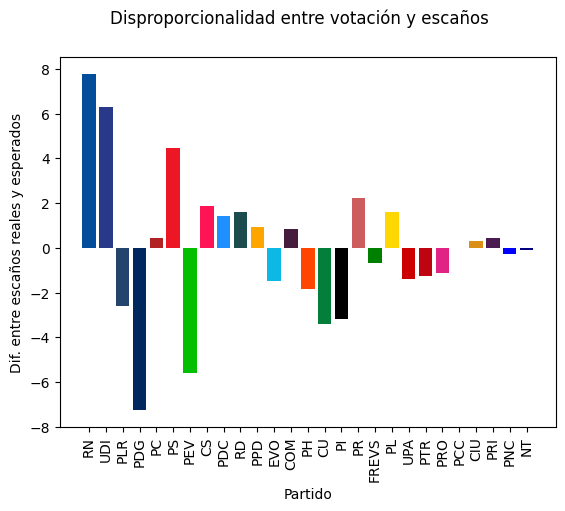

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 6.62%

Candidatos con menos votos que fueron electos:
                            Pacto Partido  Distrito  Votos (%)
Candidato                                                     
HERNAN PALMA PEREZ             DA      PH        12   0.239757
MONICA TAMARA ARCE CASTRO      DA      PH        12   0.250215
ANDRES GIORDANO SALAZAR        AD      RD         9   0.856237
MARTA AMERICA GONZALEZ OLEA   NPS     PPD        15   0.989451
ANA MARIA BRAVO CASTRO        NPS      PS        24   1.288526

Candidatos con más votos que no fueron electos:
                                    Pacto Partido  Distrito  Votos (%)
Candidato                                                             
RAMON ERNESTO GALLEGUILLOS CASTILLO  ChP+      RN         2   9.994307
ALEJANDRA VALDEBENITO TORRES         ChP+     UDI        27   9.910182
LEONARDO DANTE SOLARI ALCOTA          FSC     PLR         2   9.903423
JOHN LEANDRO SANCH

In [7]:
results_dhondt = appoint_divisor_district(
    df,
    district_seats=district_seats,
    assign_type="dhondt",
    party_threshold=0.00
)
app_dhondt = Apportionment(
    results=results_dhondt,
    colors=colors,
    party_order=party_order
)

app_dhondt.summary()

### D'Hondt con umbral nacional

Una de las reformas más mencionadas para el sistema político chileno involucra
la creación de un [umbral
electoral](https://www.t13.cl/noticia/politica/udi-presenta-proyecto-para-establecer-5-votos-para-partidos-politicos-16-1-2024)
a nivel nacional, mediante el cual partido que obtengan una votación nacional
menor al umbral no podrán competir por ningún escaño. Sistemas similares se
utilizan en la [Cámara de Diputados de
Brasil](https://en.wikipedia.org/wiki/Chamber_of_Deputies_(Brazil)), el
[Congreso de
Perú](https://en.wikipedia.org/wiki/Congress_of_the_Republic_of_Peru) y el
[Consejo Nacional de
Austria](https://en.wikipedia.org/wiki/National_Council_(Austria)), aunque cabe
mencionar que ninguno permite la creación de pactos entre partidos (como sí
ocurre en Chile).

El umbral más comúnmente propuesto es del 5%, pero en vista del *dataset* con
el cual se trabaja se utilizará un umbral del 4% para permitir que más partidos
accedan a escaños. En la realidad, se esperaría que de promulgarse esta
reforma, los partidos más pequeños se fusionaran para lograr el 5% (como ya
hizo el [Frente
Amplio](https://elpais.com/chile/2024-07-15/el-frente-amplio-la-formacion-de-boric-elige-su-primera-directiva-tras-la-union-de-sus-partidos.html)).

Características del sistema D'Hondt con umbral nacional:
- Obtiene una baja proporcionalidad nacional a nivel de partidos, con índices
  de disproporcionalidad de 12.83% (Gallagher) y 36.00% (Loosemore-Hanby). Esto
  es de esperar, pues un 28% de los votantes escogieron a partidos con menos
  del 4% de los votos, lo cual implica que no recibieron representación alguna.
  Afortunadamente la proporcionalidad a nivel de pactos es muy parecida al
  sistema estándar, pues al menos los votos "perdidos" de un partido siguen
  valiendo para elegir a candidatos de su pacto, y no son eliminados
  completamente.
- Se mantiene inclinación hacia los pactos más grandes; y ahora se agrega una
  inclinación hacia los partidos que están en pacto con muchos partidos
  pequeños, ya que "absorben" sus votos descartados. Esto es particularmente
  claro en el caso del PS, que tiene 14 diputados más de los que debería por
  proporcionalidad, gracias a que casi todos sus partidos de coalición (PPD,
  PL, PR, CIU) quedaron por debajo del 4% (solo se "salvó" el PDC).
- La proporcionalidad a nivel de distrito es similar a D'Hondt estándar, pero
  con una peor representación a nivel de partido. Un 46.99% de los votantes no
  tienen a nadie de su partido representándolos a nivel de distrito, 7% más que
  en el caso de D'Hondt estándar.
- El nivel de arrastre es incluso peor que D'Hondt estándar, pues ahora se
  pueden escoger candidatos de partidos que no tuvieron votos en el distrito,
  solamente porque son el único partido del pacto con representación a nivel
  nacional. Los 5 diputados menos votados obtuvieron bajo un 1.1% de los votos
  de su distrito, y el diputado mediano obtuvo un 5.34% de los votos de su
  distrito.
- Por otra parte, hay candidaturas que obtuvieron figuras cercanas al 20% y aún
  así no resultaron electas, debido a que su partido a nivel nacional no obtuvo
  el porcentaje necesario. Este dato, contrastado con el alto arrastre, muy
  probablemente no sean bienvenidos por la ciudadanía que espera que los
  candidatos por los cuales ellos votan salgan electos.
- Hay un menor grado de fragmentación partidaria, con solo 10 partidos
  representados en la Cámara, y 7.93 partidos efectivos. La baja diferencia
  entre partidos reales y efectivos indica que la mayoría de partidos tienen
  una presencia notoria en el Congreso (solo el PEV y el PDG tienen menos de 10
  diputados).

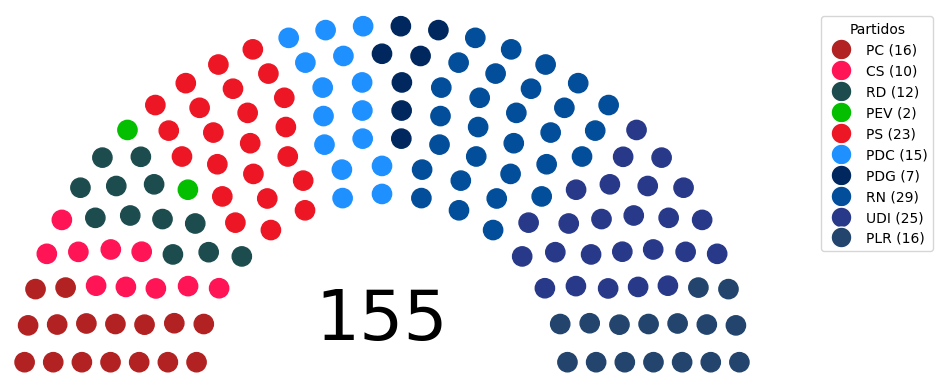

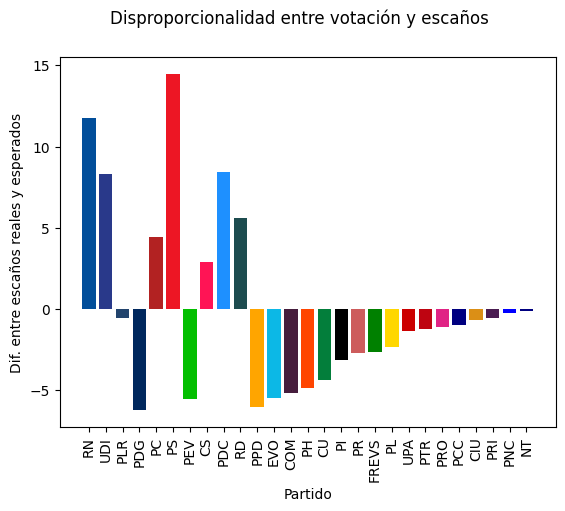

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 5.34%

Candidatos con menos votos que fueron electos:
                                      Pacto Partido  Distrito  Votos (%)
Candidato                                                               
GABRIELA DEL CARMEN MANCILLA MATELUNA   NPS     PDC         4   0.623195
PAULA NIEVAS SILVA                      NPS      PS         3   0.812071
ANDRES GIORDANO SALAZAR                  AD      RD         9   0.856237
CLAUDIA DEL PILAR FAUNDEZ FUENTES      ChP+      RN        12   0.904702
LUCIANO VALLE ACEVEDO                   NPS      PS         6   1.103760

Candidatos con más votos que no fueron electos:
                          Pacto Partido  Distrito  Votos (%)
Candidato                                                   
RAUL SOTO MARDONES          NPS     PPD        15  27.868778
VLADO MIROSEVIC VERDUGO     NPS      PL         1  20.905373
PAMELA JILES MORENO          DA      PH        12  19.79095

In [8]:
results_dhondt_threshold = appoint_divisor_district(
    df,
    district_seats=district_seats,
    assign_type="dhondt",
    party_threshold=0.04
)
app_dhondt_threshold = Apportionment(
    results=results_dhondt_threshold,
    colors=colors,
    party_order=party_order
)

app_dhondt_threshold.summary()

### D'Hondt sin pactos

Otra idea que se ha propuesto para el sistema político chileno (aunque sin
particular apoyo parlamentario) consiste en la [eliminación de los pactos entre
partidos](https://www.ciperchile.cl/2024/11/07/reforma-al-sistema-politico-vamos-al-fondo-del-problema/)
para las elecciones. Como se mencionó en la sección anterior, este sistema (con
umbrales nacionales) se utiliza en países como Brasil, Perú y Austria. También
se usa con umbrales a nivel de distrito en la [Cámara de Representantes de
Colombia](https://en.wikipedia.org/wiki/Chamber_of_Representatives_of_Colombia).

**Observación**: en la simulación realizada, se usaron los datos sin pactos,
pero esta información se volvió a agregar tras la simulación para poder
analizar métricas sobre los "pactos" que se formarían *de facto* en el
Congreso.

Características del sistema D'Hondt sin pactos:
- Obtiene proporcionalidad similar a D'Hondt estándar a nivel de partidos, con
  índices de disproporcionalidad de 7.51% (Gallagher) y 18.50%
  (Loosemore-Hanby).
- Hay una muy clara inclinación hacia los partidos más grandes, con cada uno de
  los 4 partidos más votados (UDI, RN, PLR, PDG) obteniendo 5 escaños más de
  los que deberían por propocionalidad. Esto es particularmente problemático
  para los partidos de izquierda, pues tienden a ser varios partidos más
  pequeños (versus los pocos partidos grandes de la derecha); de implementarse
  este sistema, probablemente veríamos la fusión de partidos pequeños.
- La proporcionalidad a nivel de distrito es similar a D'Hondt estándar, tanto
  para partidos como para pactos. Este es un resultado sorprendente, pues uno
  esperaría que un voto con más información (partido + pacto) entregaría
  resultados más proporcionales respecto a un voto con menos información (solo
  partido, sin saber nada de pactos).
- El nivel de arrastre es similar a D'Hondt estándar, y mejor que D'Hondt con
  umbral nacional. El candidato mediano fue electo con un 6.55% de los votos de
  su distrito.
- El grado de fragmentación parlamentaria es un poco menor que D'Hondt
  estándar, y mayor que D'Hondt con umbral nacional. Hay 19 partidos en el
  parlamento, y 9.64 partidos efectivos.
- Es interesante notar que utilizar D'Hondt con listas abiertas y sin pactos
  inflaría el tamaño de las papeletas, ya que cada partido intentaría competir
  con la mayor cantidad de candidatos posibles (aunque sea infactible que todos
  salgan electos). Una solución para esto sería utilizar listas cerradas (donde
  las personas solo votan por el partido), pero esto podría hacer mella en una
  sociedad chilena que [no aprueba de los partidos
  políticos](https://www.latercera.com/nacional/noticia/cadem-mas-del-90-se-declara-insatisfecho-con-el-funcionamiento-del-poder-judicial-y-del-sistema-politico-chileno/OX4AAAQ7KRHLVKRIPPEQVVKVW4/).

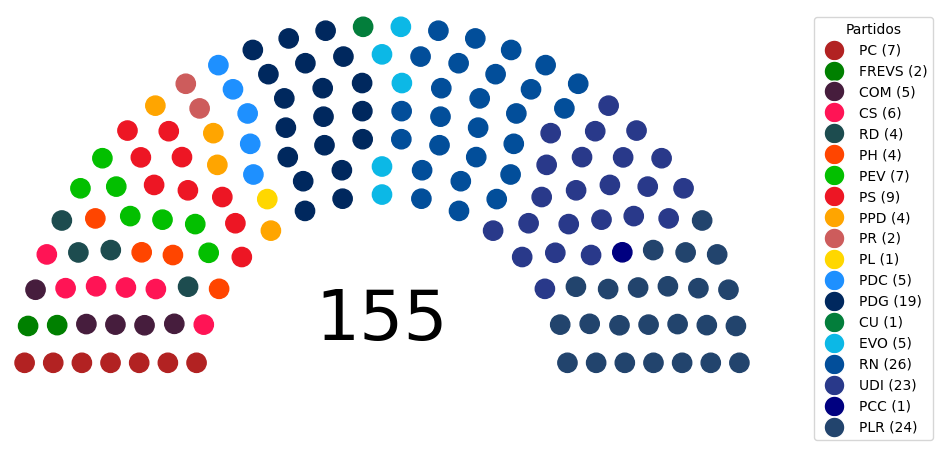

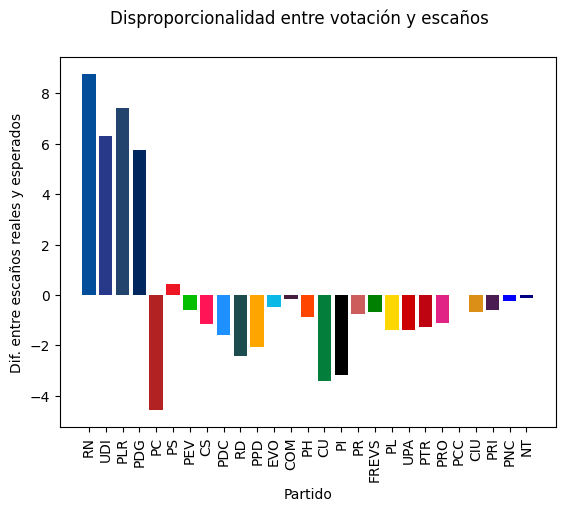

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 6.55%

Candidatos con menos votos que fueron electos:
                                 Pacto Partido  Distrito  Votos (%)
Candidato                                                          
HERNAN PALMA PEREZ                  DA      PH        12   0.239757
MONICA TAMARA ARCE CASTRO           DA      PH        12   0.250215
MARTA AMERICA GONZALEZ OLEA        NPS     PPD        15   0.989451
ANA MARIA BRAVO CASTRO             NPS      PS        24   1.288526
MARIA SOLEDAD CASTILLO HENRIQUEZ  ChP+      RN        22   1.440352

Candidatos con más votos que no fueron electos:
                                    Pacto Partido  Distrito  Votos (%)
Candidato                                                             
RAMON ERNESTO GALLEGUILLOS CASTILLO  ChP+      RN         2   9.994307
ALEJANDRA VALDEBENITO TORRES         ChP+     UDI        27   9.910182
MATIAS FELIPE RAMIREZ PASCAL           AD      PC     

In [ ]:
results_dhondt_no_pact = appoint_divisor_district(
    df_no_pact,
    district_seats=district_seats,
    assign_type="dhondt",
    party_threshold=0.00
)
results_dhondt_no_pact.loc[:, "pact"] = df["pact"]

app_dhondt_no_pact = Apportionment(
    results=results_dhondt_no_pact,
    colors=colors,
    party_order=party_order
)

app_dhondt_no_pact.summary()

## Sistemas proporcionales nacionales

Los sistemas proporcionales nacionales son muy similares a los sitemas por distrito, solo que suman todos los votos en un único "distrito nacional". Para efectos de esta simulación, se realizará la elección de los diputados de cada partido en base a la cantidad de votos que obtuvieron, y **no se utilizarán pactos electorales**.

Características de los sistemas proporcionales nacionales:

* Logran una mayor representatividad a nivel nacional que los sistemas proporcionales por distrito.
* Como no existe el concepto de distrito, no hay ninguna certeza de que haya representantes de todas las zonas del país en el parlamento. En nuestra simulación, esto se verá reflejado en que los distritos más pequeños (como Aysén o Magallanes) no tendrán ningún candidato que haya alcanzado los votos suficientes como para ser electo, quedándose así sin representación.

### D'Hondt nacional con umbral bajo

La mayoría de países que implementan D'Hondt nacional tienen umbrales
electorales muy pequeños o nulos. Para la [Cámara de Representantes de los
Países
Bajos](https://en.wikipedia.org/wiki/House_of_Representatives_(Netherlands)),
el umbral es equivalente al porcentaje que representa un escaño en el
parlamento (1/150, pues son 150 escaños). En el caso del [Senado de
Uruguay](https://en.wikipedia.org/wiki/Senate_of_Uruguay), no existen umbrales
electorales, aunque debido a la baja cantidad de escaños existe un **umbral
natural** relativamente alto.

Para esta simulación, se decidió usar un umbral electoral como el de los Países
Bajos, aunque en nuestro caso sería 1/155 pues son 155 escaños en la Cámara.
Las diferencias son mínimas si no se usa un umbral, ya que Ciudadanos y el PRI
serían los únicos partidos nuevos que ingresarían al Congreso.

Características de D'Hondt nacional con umbral bajo:
- Obtiene excelentes niveles de proporcionalidad a nivel nacional, con índices
  de disproporcionalidad de 0.85% (Gallagher) y 2.74% (Loosemore-Hanby).
- Hay una leve inclinación hacia partidos más grandes, pero todos están dentro
  de 1.5 escaños de su proporción esperada.
- Como los votos se contaron en una lista nacional, hay algunos distritos que
  no tienen representación alguna. Esto hace que aunque solo un 37.66% de
  personas no tienen a nadie de su partido representándolos en su distrito, hay
  tres distritos donde un 100% de las personas sufren ese problema (pues no
  escogieron a ningún diputado). Aunque esto sea una simulación, sí refleja el
  problema principal de las listas nacionales: la falta de representación
  asegurada para las zonas menos pobladas del país.
- Aunque el concepto de "arrastre" no aplica en este caso, sí es cierto que el
  diputado mediano obutvo solo el 5.68% de los votos de su distrito, y los 5
  diputados menos votados están bajo el 1.7%.
- El grado de fragmentación parlamentaria es altísimo, con 23 partidos en el
  Congreso, y 13.78 partidos efectivos. Este nivel de fragmentación es una
  característica conocida del sistema político neerlandés, hasta el punto que
  ["Dutchification"](https://www.euractiv.com/section/politics/opinion/the-brief-dutchification-is-pushing-europes-governments-to-the-brink/)
  se ha utilizado como sinónimo de fragmentación política.
- Con un único distrito a nivel nacional, sin pactos y con 155 escaños para
  llenar, las papeletas pueden llegar a ser [extraordinariamente
  grandes](https://www.washingtonpost.com/news/worldviews/wp/2017/03/15/with-28-parties-running-dutch-voters-have-to-use-these-literally-enormous-ballots/),
  aunque en los Países Bajos se están probando [métodos
  alternativos](https://nltimes.nl/2024/03/11/five-dutch-municipalities-experiment-small-ballot-european-elections)
  para hacerlas más manejables.

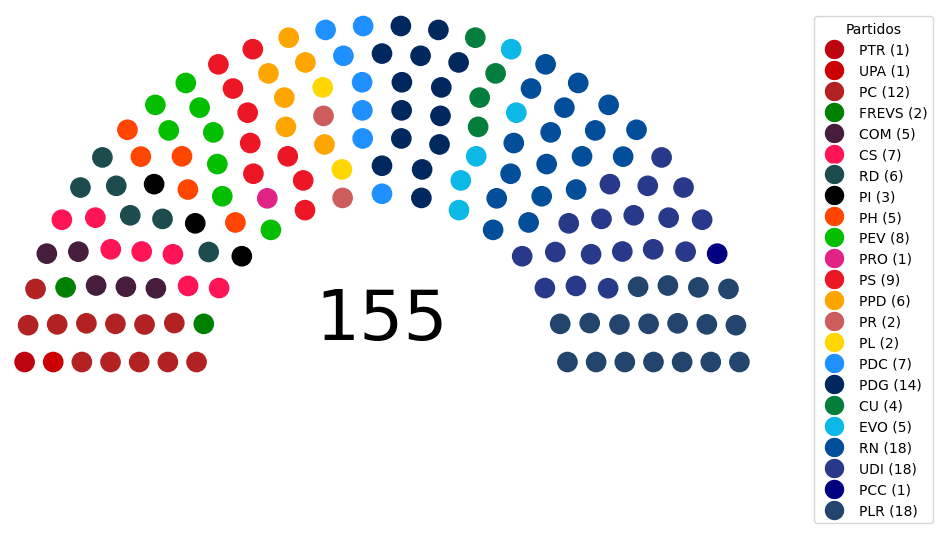

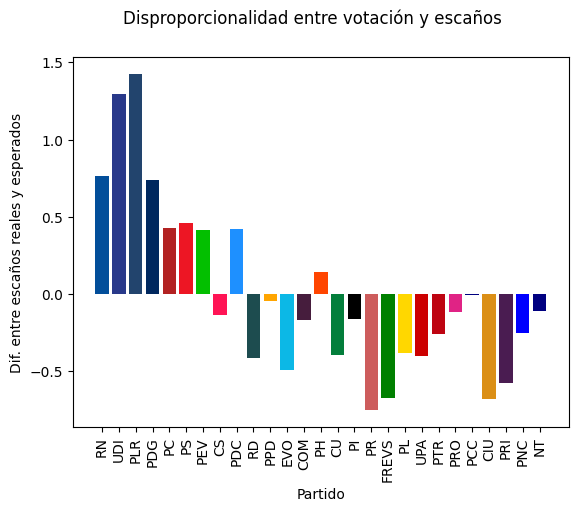

RESUMEN DE ESTADÍSTICAS:
            
Mediana de votación para candidatos electos: 7.16%

Candidatos con menos votos que fueron electos:
                                    Pacto Partido  Distrito  Votos (%)
Candidato                                                             
MARCIA DEL CARMEN MILLAQUEO IBARRA    PRO     PRO        14   1.709003
LESTER PATRICIO CALDERON HERNANDEZ    PTR     PTR         3   1.778429
GONZALO DEL CARMEN RUBIO FUENZALIDA   UPA     UPA        16   1.995138
AUCAN HUILCAMAN PAILLAMA               DA      PI        23   2.541947
CAROLINA FERNANDEZ GONZALEZ           PEV     PEV        15   2.788590

Candidatos con más votos que no fueron electos:
                                 Pacto Partido  Distrito  Votos (%)
Candidato                                                          
ENRIQUE LEE FLORES                ChP+     PRI         1   9.098480
TOMAS IGNACIO LAGOMARSINO GUZMAN   NPS      PR         7   7.397820
FELIX BUGUEÑO SOTELO                AD   FREV

In [ ]:
results_dhondt_nat = appoint_divisor_national(
    df_no_pact,
    total_seats=155,
    assign_type="dhondt",
    party_threshold=1/155
)
results_dhondt_nat.loc[:, "pact"] = df["pact"]

app_dhondt_nat = Apportionment(
    results=results_dhondt_nat,
    colors=colors,
    party_order=party_order
)

app_dhondt_nat.summary()